# TF—IDF features

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords 

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          y_title=1.10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(pd.DataFrame(cm, columns=classes, index=classes))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, y=y_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes, rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# read df
df = spark.read.parquet('/Users/zhengxin/Desktop/spark/final/output/data')
df.show()

+------+--------------------+
| label|                diff|
+------+--------------------+
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|unsafe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|unsafe|{{short descripti...|
|unsafe|{{short descripti...|
|unsafe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|vandal|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
|  safe|{{short descripti...|
+------+--------------------+
only showing top 20 rows



In [6]:
# split data into train and test data
(train, test) = df.randomSplit([0.8,0.2], seed = 775346)
print('train Data Count:' + str(train.count()))
print('test data count:' + str(test.count()))

train Data Count:737
test data count:164


In [7]:
train.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe|  439|
|unsafe|  211|
|vandal|   87|
+------+-----+



In [8]:
test.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe|   96|
|unsafe|   44|
|vandal|   24|
+------+-----+



In [9]:
## feature transformer: 
# tokenizer (split sentences into words)
regexTokenizer = RegexTokenizer(inputCol = 'diff', outputCol = 'words', pattern = '\\W')   

In [10]:
locale = sc._jvm.java.util.Locale
print(locale.getDefault()) ##en_CN
locale.setDefault(locale.forLanguageTag("en-US"))
print(dir(locale))
locale.setDefault(locale.forLanguageTag("en-US"))
print(locale.getDefault()) #en_US

en_CN
['Builder', 'CANADA', 'CANADA_FRENCH', 'CHINA', 'CHINESE', 'Category', 'ENGLISH', 'FRANCE', 'FRENCH', 'FilteringMode', 'GERMAN', 'GERMANY', 'ITALIAN', 'ITALY', 'JAPAN', 'JAPANESE', 'KOREA', 'KOREAN', 'LanguageRange', 'PRC', 'PRIVATE_USE_EXTENSION', 'ROOT', 'SIMPLIFIED_CHINESE', 'TAIWAN', 'TRADITIONAL_CHINESE', 'UK', 'UNICODE_LOCALE_EXTENSION', 'US', 'filter', 'filterTags', 'forLanguageTag', 'getAvailableLocales', 'getDefault', 'getISOCountries', 'getISOLanguages', 'lookup', 'lookupTag', 'setDefault']
en_US


In [11]:
# remove the stop words
import nltk
nltk.download('stopwords')
stopwordList = nltk.corpus.stopwords.words('english')
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwordList)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhengxin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# count bag of words
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=20000, minDF=0)

In [13]:
# encoding dependent feature 'label'
label_stringIdx = StringIndexer(inputCol="label", outputCol="labelIndex")
labels_stars = label_stringIdx.fit(train).labels
indexed = label_stringIdx.fit(df).transform(df)

In [14]:
# TF-IDF features
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq = 5)

In [15]:
# create a pipeline
pipeline_tfidf = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF , idf, label_stringIdx])

In [16]:
# appply pipeline to train and test data
pipelineFit_tfidf = pipeline_tfidf.fit(train)
train_pipe_tfidf = pipelineFit_tfidf.transform(train)
train_pipe_tfidf.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|                diff|               words|            filtered|         rawFeatures|            features|labelIndex|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| safe|{{short descripti...|[short, descripti...|[short, descripti...|(262144,[42,97,17...|(262144,[42,97,17...|       0.0|
| safe|{{short descripti...|[short, descripti...|[short, descripti...|(262144,[42,97,17...|(262144,[42,97,17...|       0.0|
| safe|{{short descripti...|[short, descripti...|[short, descripti...|(262144,[42,97,17...|(262144,[42,97,17...|       0.0|
| safe|{{short descripti...|[short, descripti...|[short, descripti...|(262144,[42,97,17...|(262144,[42,97,17...|       0.0|
| safe|{{short descripti...|[short, descripti...|[short, descripti...|(262144,[42,97,17...|(262144,[42,97,17...|       0.0|
+-----+-

In [21]:
label_str = list(train_pipe.select("label").toPandas()['label'].unique())
label_num = [0,1,2]
map_num_2_str = dictionary = dict(zip(label_num, label_str))
print(map_num_2_str)

{0: 'safe', 1: 'unsafe', 2: 'vandal'}


### logistic regression

In [22]:
# fit a model 
lr = LogisticRegression(featuresCol = 'features', labelCol = 'labelIndex', maxIter = 10, regParam = 0, elasticNetParam=0)

In [23]:
lrModel = lr.fit(train_pipe_tfidf)

### Evaluation on test data

In [24]:
test_pipe_tfidf = pipelineFit_tfidf.transform(test)

In [25]:
# predict with test_pipe data
pred_test = lrModel.transform(test_pipe_tfidf)
pred_test.select("labelIndex","label", "probability", "prediction").show()
pred_test

+----------+------+--------------------+----------+
|labelIndex| label|         probability|prediction|
+----------+------+--------------------+----------+
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       0.0|  safe|[0.59158735589655...|       0.0|
|       1.0|unsafe|[0.59158735589655...|       0.0|
|       1.0|unsafe|[0.59158735589655...|       0.0|
|       1.0|

DataFrame[label: string, diff: string, words: array<string>, filtered: array<string>, rawFeatures: vector, features: vector, labelIndex: double, rawPrediction: vector, probability: vector, prediction: double]

## A) Confusion Matrix

In [26]:
class_names = ['unsafe','safe', 'vandal']
y_true_test = pred_test.select("label").toPandas()
y_pred_test = pred_test.select("prediction").toPandas()
y_pred_test = y_pred_test['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix_test = confusion_matrix(y_true=y_true_test, y_pred=y_pred_test, labels=class_names)
pd.DataFrame(cnf_matrix_test, columns=class_names, index=class_names)

,unsafe,safe,vandal
unsafe,0,42,0
safe,0,99,0
vandal,0,23,0


Confusion matrix, without normalization
        unsafe  safe  vandal
unsafe       0    42       0
safe         0    99       0
vandal       0    23       0


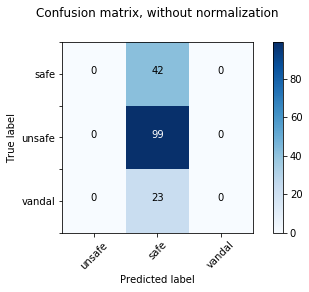

In [27]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
plt.yticks([2.5,2,1.5,1,0.5,0,-.5], ["",label_str[2],"",label_str[1],"",label_str[0]]);

In [28]:
# Accuaracy and F1
evaluator_acc = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='labelIndex', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='labelIndex', metricName="f1")
print(f"Accuracy: {round(evaluator_acc.evaluate(pred_test), 4)}")
print(f"F1 score: {round(evaluator_f1.evaluate(pred_test), 4)}")

Accuracy: 0.6037
F1 score: 0.4545


In [29]:
# AUC
results = pred_test.select(['probability', 'labelIndex'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.5


## B) Crossvalidation

In [30]:
# crossvalidation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [31]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [32]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator_acc, 
                    numFolds=5)

In [33]:
cvModel = cv.fit(train_pipe_tfidf)  # be careful, takes very long time

In [34]:
# predict with test_pipe data
predictions = cvModel.transform(test_pipe_tfidf)
predictions

DataFrame[label: string, diff: string, words: array<string>, filtered: array<string>, rawFeatures: vector, features: vector, labelIndex: double, rawPrediction: vector, probability: vector, prediction: double]

In [35]:
# evaluate best model---accuracy
accuracy = evaluator_acc.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

# F1 score
F1 = evaluator_f1.evaluate(predictions)
print("Test set F1 score = " + str(F1))

Test set accuracy = 0.6036585365853658
Test set F1 score = 0.45446536214411576


### Naive Bayes

In [36]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1, modelType="multinomial", featuresCol = 'features', labelCol = 'labelIndex' )

In [37]:
# train model with train_pipe data 
model = nb.fit(train_pipe_tfidf)

In [38]:
# make predictions
pred_test = model.transform(test_pipe_tfidf)
pred_test

DataFrame[label: string, diff: string, words: array<string>, filtered: array<string>, rawFeatures: vector, features: vector, labelIndex: double, rawPrediction: vector, probability: vector, prediction: double]

In [39]:
class_names = ['unsafe','safe', 'vandal']
y_true_test = pred_test.select("label").toPandas()
y_pred_test = pred_test.select("prediction").toPandas()
y_pred_test = y_pred_test['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix_test = confusion_matrix(y_true=y_true_test, y_pred=y_pred_test, labels=class_names)
pd.DataFrame(cnf_matrix_test, columns=class_names, index=class_names)

,unsafe,safe,vandal
unsafe,0,42,0
safe,0,99,0
vandal,0,23,0


Confusion matrix, without normalization
        unsafe  safe  vandal
unsafe       0    42       0
safe         0    99       0
vandal       0    23       0


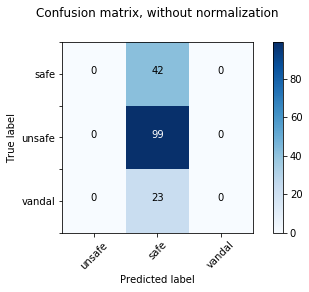

In [40]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
plt.yticks([2.5,2,1.5,1,0.5,0,-.5], ["",label_str[2],"",label_str[1],"",label_str[0]]);

In [41]:
# Accuaracy and F1
print(f"Accuracy: {round(evaluator_acc.evaluate(pred_test), 4)}")
print(f"F1 score: {round(evaluator_f1.evaluate(pred_test), 4)}")

Accuracy: 0.6037
F1 score: 0.4545


In [60]:
# AUC
results = pred_test.select(['probability', 'labelIndex'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.5


### Random Forrest

In [42]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="labelIndex", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

In [43]:
# Train model with Train_pipe Data
rfModel = rf.fit(train_pipe_tfidf)

In [44]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200, 500]) 
             .addGrid(rf.maxDepth, [4, 10, 20])
             .build())

In [45]:
#  Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator_acc, 
                    numFolds=5)

In [46]:
# Cross_validation train
cvmodel = cv.fit(train_pipe)  # be careful, takes very long time

In [47]:
# predict with test_pipe data
predictions = cvModel.transform(test_pipe_tfidf)
predictions

# evaluate best model---accuracy
accuracy = evaluator_acc.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

# F1 score
F1 = evaluator_f1.evaluate(predictions)
print("Test set F1 score = " + str(F1))

Test set accuracy = 0.6036585365853658
Test set F1 score = 0.45446536214411576
